# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

**DATA Task**

The objective of this task to conduct a multivariate analysis to identiy and quantify the impact of various features on the price of used cars. This requires a dataset containing variables such as manufacturer, model, age, odometer reading, condition, price, geograhical location, and other relavant features. After cleaning-up / pre-processing the data to handle missing values, duplicate values and outliers, feature selection techniques will be applied to identify key features that impact the price of the car. Multiple regression models will be developed and validated to estimate the price of the car based on the key features. The best regression model will be chosen based on the lowest error. The final model will be used to provide insights to used car dealers to understand what drives the price of a used car with the ultimate objective to flip used cars for profit.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [406]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression, RidgeCV
from category_encoders.target_encoder import TargetEncoder

In [407]:
# Step 1: Load the dataset
vehicles = pd.read_csv('data/vehicles.csv')

In [408]:
# Step 2: Descriptive statistics
print(vehicles.describe(include='all'))
print("\nData types:\n", vehicles.dtypes)

                  id    region         price           year manufacturer  \
count   4.268800e+05    426880  4.268800e+05  425675.000000       409234   
unique           NaN       404           NaN            NaN           42   
top              NaN  columbus           NaN            NaN         ford   
freq             NaN      3608           NaN            NaN        70985   
mean    7.311487e+09       NaN  7.519903e+04    2011.235191          NaN   
std     4.473170e+06       NaN  1.218228e+07       9.452120          NaN   
min     7.207408e+09       NaN  0.000000e+00    1900.000000          NaN   
25%     7.308143e+09       NaN  5.900000e+03    2008.000000          NaN   
50%     7.312621e+09       NaN  1.395000e+04    2013.000000          NaN   
75%     7.315254e+09       NaN  2.648575e+04    2017.000000          NaN   
max     7.317101e+09       NaN  3.736929e+09    2022.000000          NaN   

         model condition    cylinders    fuel      odometer title_status  \
count   421

In [409]:
vehicles.sample(10)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
139828,7306211750,champaign urbana,12990,2014.0,ford,e150 econoline van,excellent,NaN,gas,134800.0,clean,automatic,NaN,NaN,full-size,van,NaN,il
201457,7311798987,grand rapids,17105,2020.0,kia,forte fe 4d sedan manual,NaN,NaN,gas,5175.0,clean,manual,3KPF24AD6LE229954,fwd,NaN,sedan,grey,mi
398697,7306856843,roanoke,7995,2012.0,nissan,juke,NaN,NaN,gas,74532.0,clean,automatic,JN8AF5MR9CT117690,fwd,compact,wagon,blue,va
70735,7312592013,yuba-sutter,10588,2012.0,volkswagen,tiguan,excellent,NaN,gas,78813.0,clean,automatic,NaN,fwd,NaN,SUV,black,ca
377664,7310362958,laredo,23995,2020.0,toyota,corolla,NaN,NaN,gas,21652.0,clean,automatic,JTDFPRAE5LJ024555,fwd,NaN,sedan,blue,tx
34728,7315962522,los angeles,3000,2002.0,volkswagen,golf,fair,4 cylinders,gas,209554.0,clean,automatic,NaN,NaN,compact,hatchback,blue,ca
47623,7306571957,redding,23590,2016.0,volvo,xc70 t5 classic platinum,good,NaN,gas,70223.0,clean,automatic,YV440MBY3G1261877,fwd,NaN,wagon,brown,ca
114327,7313354045,space coast,5300,2007.0,toyota,sienna,excellent,6 cylinders,gas,144000.0,clean,automatic,NaN,NaN,NaN,van,NaN,fl
121012,7307501364,athens,6799,2006.0,honda,accord lx,NaN,NaN,gas,147285.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,ga
311631,7314606409,bend,6000,2010.0,ford,escape,excellent,6 cylinders,gas,145700.0,clean,automatic,1FMCU0DGXAKD02177,fwd,NaN,SUV,NaN,or


In [410]:
# Step-3: Data Quality Assessment 
# Determine percentage of missing data
print("\n% Missing values:\n", (vehicles.isnull().sum() / len(vehicles)) * 100)


% Missing values:
 id               0.000000
region           0.000000
price            0.000000
year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
state            0.000000
dtype: float64


In [411]:
# Calculate the percentage of  rows with any missing values
percentage_rows_missing_values = vehicles.isnull().any(axis=1).mean() * 100

print(f"Percentage of rows with any missing values: {percentage_rows_missing_values:.2f}%")

Percentage of rows with any missing values: 91.83%


Text(0.5, 0, 'Price Distribution')

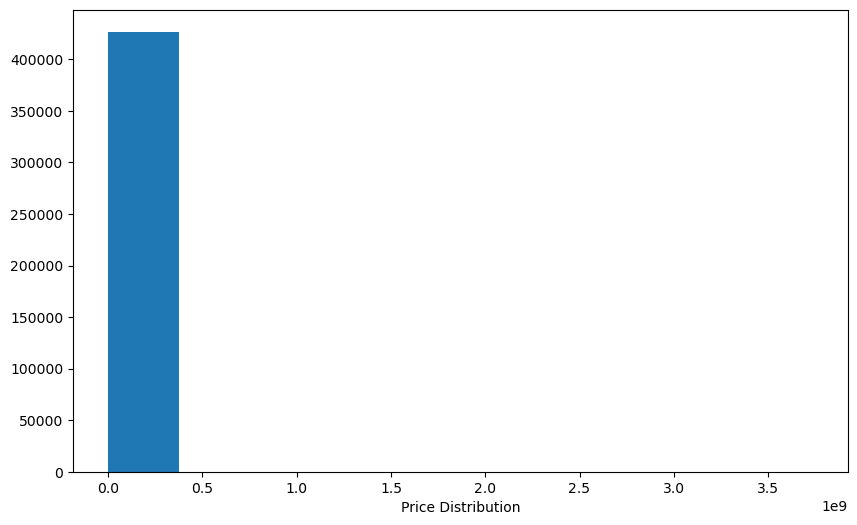

In [412]:
# Histogram of price
plt.figure(figsize=(10, 6))
plt.hist(vehicles['price'])
plt.xlabel("Price Distribution")

Text(0.5, 0, 'QQ Plot of Price')

<Figure size 1000x600 with 0 Axes>

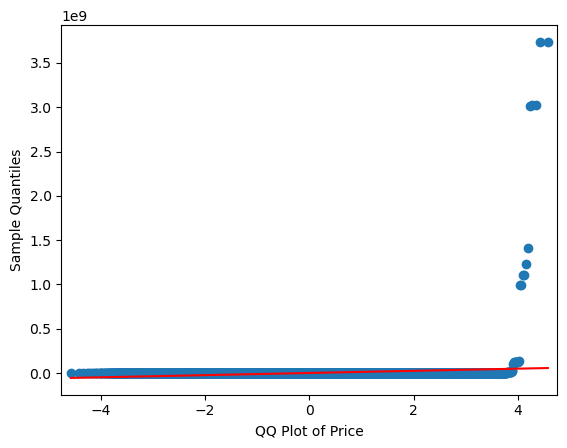

In [413]:
# QQplot of price
plt.figure(figsize=(10, 6))
sm.qqplot(vehicles['price'], line ='s')
plt.xlabel("QQ Plot of Price")

Text(0.5, 1.0, 'Correlation Heatmap of Numeric Variables')

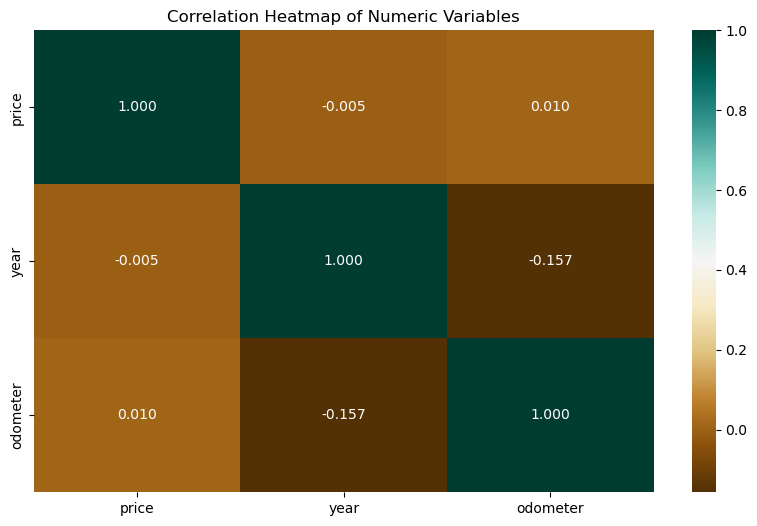

In [414]:
# Correlation heatmap of numeric variables
numeric_columns = vehicles.select_dtypes(include='number').columns
vehicles_numeric = vehicles[numeric_columns]
vehicles_numeric_clean = vehicles_numeric.drop('id', axis=1)
plt.figure(figsize=(10, 6))
sns.heatmap(vehicles_numeric_clean.corr(), fmt=".3f", annot=True, cmap='BrBG')
plt.title('Correlation Heatmap of Numeric Variables')

**Observations**

* Vehicles data is a mix of numeric and categorical features with missing and duplicate values. The mixed features will require different preprocessing methods. 
* Data contains fields that aren't relevant to building and validating the model. Ex: id.
* Data clean up will be required before building and validating a model to predict price of used cars.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

#### Handling missing data

In [418]:
# For categorical data, fill missing values with 'Unknown'
categorical_columns = ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']
essential_columns = ['manufacturer', 'model', 'condition', 'odometer', 'title_status', 'transmission', 'type', 'paint_color']
removable_columns = [column for column in categorical_columns if column not in essential_columns]

# For values in categorical columns, add 'Unknown' in place of NaN/Null
for column in categorical_columns:
    vehicles[column].fillna('Unknown', inplace=True)

# For 'year' and 'odometer', fill missing values with the median of their respective columns
vehicles['year'].fillna(vehicles['year'].median(), inplace=True)
vehicles['odometer'].fillna(vehicles['odometer'].median(), inplace=True)

# Drop duplicates based on 'VIN' column and then drop the 'VIN' column itself
# 'VIN' encodes the manufacturer, year, make and model, and the trim level including unique features and specifications
# Dropping it for now as it is in the endoded form. Future improvements could include decoding it and adding/complementing features
vehicles.drop_duplicates(subset=['VIN'], keep='first', inplace=True)
vehicles.drop(columns=['VIN'], inplace=True)

# Drop column 'id' as it doesn't seem particularly useful in predicting the price of a car
vehicles.drop(columns=['id'], inplace=True)

In [419]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118247 entries, 0 to 426833
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        118247 non-null  object 
 1   price         118247 non-null  int64  
 2   year          118247 non-null  float64
 3   manufacturer  118247 non-null  object 
 4   model         118247 non-null  object 
 5   condition     118247 non-null  object 
 6   cylinders     118247 non-null  object 
 7   fuel          118247 non-null  object 
 8   odometer      118247 non-null  float64
 9   title_status  118247 non-null  object 
 10  transmission  118247 non-null  object 
 11  drive         118247 non-null  object 
 12  size          118247 non-null  object 
 13  type          118247 non-null  object 
 14  paint_color   118247 non-null  object 
 15  state         118247 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 15.3+ MB


In [420]:
# Given how skewed the price distribution was, we want to filter the outliers using Z-score
# While at it do this for other numeric features as well (year and odometer)

def remove_outliers(df, column):
    return df[(np.abs(stats.zscore(df[column])) < 3)]

for column in vehicles.select_dtypes('number').columns:
    vehicles = remove_outliers(vehicles, column)

In [421]:
# Convert price, year and odometer from float to int
vehicles = vehicles.astype({'price': 'int', 'year': 'int', 'odometer': 'int'})

In [422]:
# Set min price to $500
vehicles.loc[vehicles['price'] < 500, 'price'] = 500

In [423]:
# Check the shape of the DataFrame after removing outliers

print(vehicles.shape)
print(vehicles.describe())

(116386, 16)
                price           year       odometer
count   116386.000000  116386.000000  116386.000000
mean     16756.996237    2013.162648   88298.495412
std      15740.399762       5.049870   56472.688614
min        500.000000    1993.000000       0.000000
25%       6000.000000    2010.000000   40762.000000
50%      13350.000000    2014.000000   85544.500000
75%      23988.000000    2017.000000  125645.250000
max    1000000.000000    2022.000000  299733.000000


In [424]:
# Lastly drop all non-essential columns
vehicles = vehicles.drop(removable_columns, axis=1)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [426]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    vehicles.drop(columns=["price"]), vehicles["price"], test_size=0.3, random_state=42)

In [427]:
# Mean encoding
mean_enc = TargetEncoder(cols=None, min_samples_leaf=25, smoothing=1.0)
X_train_enc = mean_enc.fit_transform(X_train, y_train)
X_test_enc = mean_enc.transform(X_test)

In [428]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

In [429]:
# Define a function that takes model, training and test sets and name as input and print out the CV score
def print_scores(model, X_train, y_train, X_test, y_test, name):
    print(f"{name}")
    print(f"Training set score: {model.score(X_train, y_train):.2f}")
    print(f"Test set score: {model.score(X_test, y_test):.2f}")
    scores = cross_val_score(model, X_test, y_test, cv=5)
    print(f"Cross-validation scores: {scores}")
    print(f"Mean cross-validation score: {scores.mean():.2f}\n")

In [430]:
# Linear Regression
lr = LinearRegression().fit(X_train_scaled, y_train)
print_scores(lr, X_train_scaled, y_train, X_test_scaled, y_test, "Linear Regression")

Linear Regression
Training set score: 0.34
Test set score: 0.32
Cross-validation scores: [0.36972732 0.3488608  0.34303255 0.23057128 0.34386972]
Mean cross-validation score: 0.33



In [431]:
# Ridge Regression
ridge = Ridge().fit(X_train_scaled, y_train)
print_scores(ridge, X_train_scaled, y_train, X_test_scaled, y_test, "Ridge Regression")

Ridge Regression
Training set score: 0.34
Test set score: 0.32
Cross-validation scores: [0.36972747 0.34886159 0.34303196 0.2305714  0.34386947]
Mean cross-validation score: 0.33



In [432]:
# Ridge Regression with Grid Search
ridge_grid = GridSearchCV(Ridge(), {'alpha': np.logspace(-6, 6, 13)}, cv=5).fit(X_train_scaled, y_train)
print_scores(ridge_grid.best_estimator_, X_train_scaled, y_train, X_test_scaled, y_test, "Ridge Regression with Grid Search")

Ridge Regression with Grid Search
Training set score: 0.34
Test set score: 0.32
Cross-validation scores: [0.36974036 0.3489377  0.34297257 0.23058276 0.34384269]
Mean cross-validation score: 0.33



In [433]:
# Ridge Regression with built-in cross-validation
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5).fit(X_train_scaled, y_train)
print_scores(ridge_cv, X_train_scaled, y_train, X_test_scaled, y_test, "Ridge Regression with built-in cross-validation")

Ridge Regression with built-in cross-validation
Training set score: 0.34
Test set score: 0.32
Cross-validation scores: [0.36974036 0.3489377  0.34297257 0.23058276 0.34384269]
Mean cross-validation score: 0.33



In [434]:
# Lasso Regression
lasso = Lasso().fit(X_train_scaled, y_train)
print_scores(lasso, X_train_scaled, y_train, X_test_scaled, y_test, "Lasso Regression")

Lasso Regression
Training set score: 0.34
Test set score: 0.32
Cross-validation scores: [0.36972867 0.34886673 0.34302422 0.23057512 0.34386672]
Mean cross-validation score: 0.33



In [435]:
# Lasso Regression with Grid Search
lasso_grid = GridSearchCV(Lasso(), {'alpha': [0.1, 0.01, 0.001, 0.0001]}, cv=5).fit(X_train_scaled, y_train)
print_scores(lasso_grid.best_estimator_, X_train_scaled, y_train, X_test_scaled, y_test, "Lasso Regression with Grid Search")

Lasso Regression with Grid Search
Training set score: 0.34
Test set score: 0.32
Cross-validation scores: [0.36972723 0.34886148 0.34303174 0.23057172 0.34386935]
Mean cross-validation score: 0.33



### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

**Observations**

* We built six models in all:
  * Linear Regression
  * Ridge Regression
  * Ridge Regression with Grid Search
  * Ridge Regression with built-in cross-validation
  * Lasso Regression
  * Lasso Regression with Grid Search
* All the models had the same training set score (0.34), test set score (0.34) and Mean CV score (0.33).
* Regularization: Ridge and Lasso regularization didn't have a significant performance impact over Linear Regression. Indicating either the data is not suffering from overfitting, or the regularization params uised need tuning.



**Conclusion**

* Given the performance of all models has been similar, I recommend we continue to use Linear Regression model to not overfit.

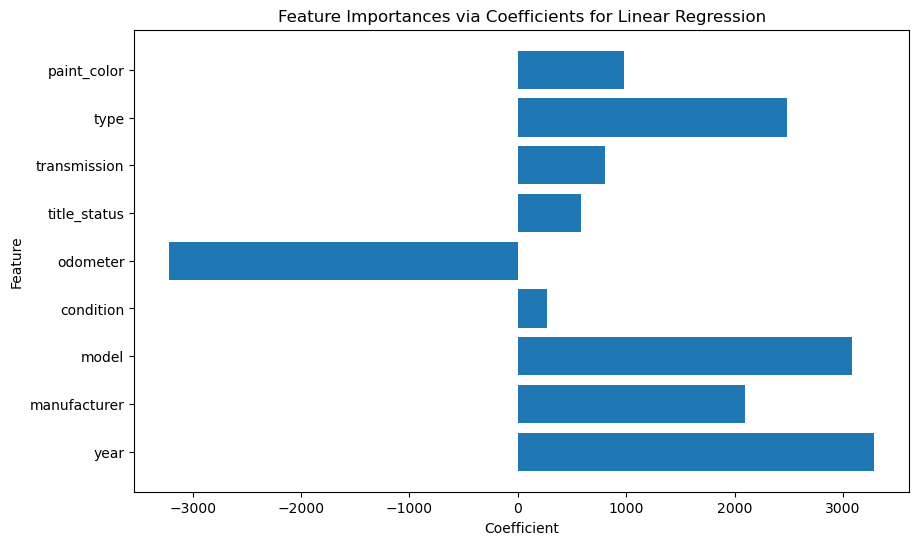

In [439]:
# Feature Importance

feature_names = X_train_enc.columns

# Feature importances via coefficients for the linear model
plt.figure(figsize=(10, 6))
plt.barh(feature_names, lr.coef_)
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Feature Importances via Coefficients for Linear Regression")
plt.show()

**Observations**

* Year (age), Odometer, Model, Type and Manufacturer are the most important features that impact the cost of the used car.
* Year, Model, Type and Manufacturer have a postive correlation.
  * Year: newer the car, higher the price.
  * Certain types of Models, Types and Manufactures have a postitive impact on the price.
  * Odometer: Negatively impacts the price. Higher the odometer rating lower the price.
* Remaining 4 other features have a postive impact on the price of the car.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

**Summary**

The factors that most influence the price of a used car are: year (age), odometer (reading), manufacturer, model and type. Maintaining a good inventory of newer cars with low odometer reading with a special focus on certain make/model/type of the vehicle will provide a competitive edge. When adding a car to the fleet run it through the model to determine the price at which the car would sell to ensure profitability.